# HEP-like INFERNO

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

## 1. Interpolation algorithm

In [2]:
from pytorch_inferno.inference import *

In [40]:
def smooth_function(x, smoothRegion = 1):
    
    mask_smooth_region = torch.abs(x) > smoothRegion
    xnorm = x / smoothRegion
    xnorm2 = xnorm*xnorm
    
    in_smooth = 0.125 * xnorm * (xnorm2 * (3.*xnorm2 - 10.) + 15)
    out_smooth = torch.where(x>0, torch.ones(x.shape), -1*torch.ones(x.shape))
    
    return torch.where(mask_smooth_region, out_smooth, in_smooth)

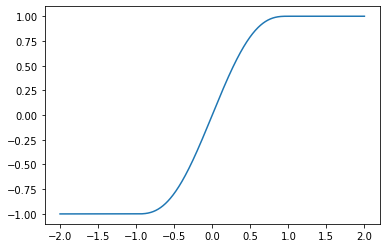

In [85]:
# Test 
x = torch.linspace(-2, 2, 1000)
y = smooth_function(x)
plt.plot(x, y)

In [112]:
def morph(x, nominal, lo, hi):
        
    dhi = hi - nominal
    dlo = lo - nominal
    #print(dhi)
    #print(dlo)
    diff_h = dhi - dlo
    sum_h = dhi + dlo
    alpha = x * 0.5 * ((diff_h) + (sum_h)*smooth_function(x))
    return alpha

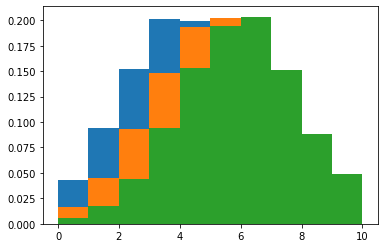

In [8]:
# Test
hi, y,_ = plt.hist(np.random.normal(loc=4, scale=2.0, size=10000), range=(0,10), density=True)
nominal, y,_ = plt.hist(np.random.normal(loc=5, scale=2.0, size=10000), range=(0,10), density=True)
lo, y,_ = plt.hist(np.random.normal(loc=6, scale=2.0, size=10000), range=(0,10), density=True)

In [115]:
hi_t = torch.Tensor(hi)
nominal_t = torch.Tensor(nominal)
lo_t = torch.Tensor(lo)

In [61]:
hi_stacked = torch.stack([hi_t, hi_t, hi_t])
lo_stacked = torch.stack([lo_t, lo_t, lo_t])

In [72]:
nominal_stacked = nominal_t.unsqueeze(0).repeat(3, 1)

In [116]:
nominal_stacked.shape

torch.Size([1000, 10])

In [110]:
alpha = torch.Tensor(np.array([-1, 0., 1.])).unsqueeze(1)

In [ ]:
nominal_stacked = nominal_t.unsqueeze(0).repeat(x.shape[0], 1)

In [118]:
nominal_stacked = nominal_t.unsqueeze(0).repeat(alpha.shape[0], 1)
morphed = morph(alpha, nominal_stacked, lo_stacked, hi_stacked)

In [107]:
nominal_t += morphed.sum(0)

In [108]:
nominal_t

tensor([0.0320, 0.0664, 0.1034, 0.1475, 0.1586, 0.1463, 0.1483, 0.1005, 0.0592,
        0.0378])

## 2. constraints

In [123]:
def normal(theta, std):
    return 1 + theta*std

In [119]:
def log_normal(theta, kappa):
    return torch.exp(theta * torch.log(kappa))

In [184]:
def logKappaForX(x, logkappa_lo, logkappa_hi):
    
    logKhi =  logkappa_hi
    logKlo = -logkappa_lo

    kappa = torch.where(x >= 0, logkappa_hi, -logkappa_lo)
    
    avg = 0.5*(logKhi + logKlo) 
    halfdiff = 0.5*(logKhi - logKlo)
    twox = x+x 
    twox2 = twox*twox
    alpha = 0.125 * twox * (twox2 * (3*twox2 - 10.) + 15.)
    ret = avg + alpha*halfdiff
    return torch.where(torch.abs(x) >= 0.5, kappa, ret)

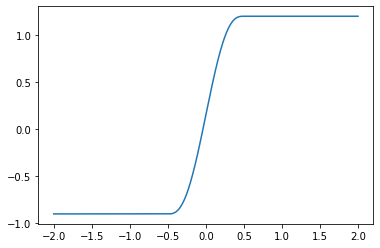

In [187]:
# Test 
x = torch.linspace(-2, 2, 1000)
y_logKappaForX = logKappaForX(x, kappa_lo, kappa_hi)
plt.plot(x, y_logKappaForX)

In [176]:
def asym_log_normal(theta, kappaLo, kappaHi):
    return torch.exp(theta * logKappaForX(theta, torch.log(kappaLo), torch.log(kappaHi)))

In [197]:
theta = torch.Tensor([1.0])
kappa = torch.Tensor([1.1])
std = torch.Tensor([0.1])
kappa_lo = torch.Tensor([0.9])
kappa_hi = torch.Tensor([1.2])
kappa_std_avg = (abs(kappa_hi-1)+abs(1-kappa_lo))/2

In [198]:
kappa_std_avg

tensor([0.1500])

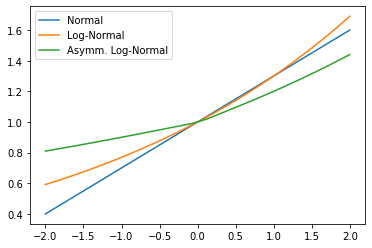

In [195]:
# Test 
x = torch.linspace(-2, 2, 1000)
y_norm = normal(x, (kappa_lo + (1+1-kappa_hi)/2 - 1))
y_ln = log_normal(x, (kappa_lo + (1+1-kappa_hi)/2))
y_lnasym = asym_log_normal(x, kappa_lo, kappa_hi)
plt.plot(x, y_norm, label="Normal")
plt.plot(x, y_ln, label="Log-Normal")
plt.plot(x, y_lnasym, label="Asymm. Log-Normal")
plt.legend()

tensor([0.3000])

## 3. NLL

In [158]:
from typing import *
from torch import Tensor
from torch.distributions import Distribution

In [159]:
def nll(s_true:float, b_true:float, mu:Tensor, f_s_nom:Tensor, f_b_nom:Tensor,
             shape_alpha:Optional[Tensor]=None, s_norm_alpha:Optional[Tensor]=None, b_norm_alpha:Optional[Tensor]=None,
             f_s_up:Optional[Tensor]=None, f_s_dw:Optional[Tensor]=None,
             f_b_up:Optional[Tensor]=None, f_b_dw:Optional[Tensor]=None,
             s_norm_aux:Optional[Distribution]=None, b_norm_aux:Optional[Distribution]=None, shape_aux:Optional[List[Distribution]]=None,
             interp_algo:str="fast_vertical") -> Tensor:
    r'''Compute negative log-likelihood for specified parameters.'''
    
    #  Interpolate shapes
    if interp_algo == "fast_vertical":
        f_s = fast_vertical(shape_alpha, f_s_nom, f_s_up, f_s_dw) if shape_alpha is not None and f_s_up is not None else f_s_nom
        f_b = fast_vertical(shape_alpha, f_b_nom, f_b_up, f_b_dw) if shape_alpha is not None and f_b_up is not None  else f_b_nom        
    else:
        f_s = interp_shape(shape_alpha, f_s_nom, f_s_up, f_s_dw) if shape_alpha is not None and f_s_up is not None else f_s_nom
        f_b = interp_shape(shape_alpha, f_b_nom, f_b_up, f_b_dw) if shape_alpha is not None and f_b_up is not None  else f_b_nom
    
    # Normalizations !!! careful if signal and background shapes mix!!
    s_exp, b_exp = mu, b_true
    if shape_alpha is not None:
        mu *= normal(shape_alpha, shape_norm_sigma).prod()
    if s_norm_aux is not None:
        mu *= normal(s_norm_alpha, s_norm_sigma).prod()
    if b_norm_alpha is not None:
        b_exp *= normal(b_norm_alpha, b_norm_sigma).prod()
    #  Compute NLL
    t_exp = (s_exp*f_s)+(b_exp*f_b)
    asimov = (s_true*f_s_nom)+(b_true*f_b_nom)
    nll = -torch.distributions.Poisson(t_exp, False).log_prob(asimov).sum()
    # Constrain nuisances
    if shape_aux is not None:
        if len(shape_aux) != len(shape_alpha): raise ValueError("Number of auxillary measurements must match the number of nuisance parameters.\
                                                           Pass `None`s for unconstrained nuisances.")
        for a,x in zip(shape_alpha, shape_aux):
            if x is not None: nll = nll-x.log_prob(a)
    if b_norm_alpha is not None:
        for a,x in zip(b_norm_alpha, b_norm_aux): nll = nll-x.log_prob(a)
    if s_norm_alpha is not None:
        for a,x in zip(s_norm_alpha, s_norm_aux): nll = nll-x.log_prob(a)
    return nll

## 4. Setup INFERNO

In [165]:
from pytorch_inferno.inferno import AbsInferno
from fastcore.all import store_attr, delegates, is_close

In [166]:
class HEPInferno(AbsInferno):
    r'''Implementation of INFERNO with HEP like systematics'''
    @delegates(AbsInferno)
    def __init__(self, interp_algo:str="default", alpha_sigmas:Optional[List[float]]=None, **kwargs):
        super().__init__(**kwargs)
        self.interp_algo = interp_algo
        self.alpha_sigmas = alpha_sigmas
        self.

    def _aug_data(self): pass  # Override abs method
    def on_batch_begin(self) -> None: pass
    def on_batch_end(self) -> None: pass

    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct        
        alpha = torch.zeros((self.n_alpha), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): alpha[self.poi_idx] += self.mu_true
    
    def _get_up_down(self, x_s:Tensor, x_b:Tensor, w_s:Optional[Tensor]=None, w_b:Optional[Tensor]=None) -> Tuple[Tuple[Optional[Tensor],Optional[Tensor]],Tuple[Optional[Tensor],Optional[Tensor]]]:

        u,d = [],[]
        # modified template variations
        for i in range(self.n_shape_alphas):
            idx_up = 1 + 2*i
            idx_down = 2 + 2*i
            up_batch = self.to_shape(self.wrapper.model(x_s[:,:,idx_up]))
            down_batch = self.to_shape(self.wrapper.model(x_s[:,:,idx_down]))
            u.append(up_batch)
            d.append(down_batch)    
        return (torch.stack(u),torch.stack(d)), (None,None)

    def get_ikk(self, f_s_nom:Tensor, f_b_nom:Tensor, f_s_up:Optional[Tensor], f_s_dw:Optional[Tensor], f_b_up:Optional[Tensor], f_b_dw:Optional[Tensor]) -> Tensor:
        r'''Compute full hessian at true param values, or at random starting values with Newton updates'''
        get_nll = partialler(nll, s_true=self.mu_true, b_true=self.b_true,
                             f_s_nom=f_s_nom, f_b_nom=f_b_nom, f_s_up=f_s_up, f_s_dw=f_s_dw,
                             f_b_up=f_b_up, f_b_dw=f_b_dw, shape_aux=self.shape_aux, s_norm_aux=self.s_norm_aux, b_norm_aux=self.b_norm_aux)
        nll = get_nll(mu=alpha[self.poi_idx], s_norm_alpha=alpha[self.s_norm_idxs], b_norm_alpha=alpha[self.b_norm_idxs], shape_alpha=alpha[self.shape_idxs],
                     interp_algo = self.interp_algo)
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        return torch.inverse(h)[self.poi_idx,self.poi_idx]

    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        b = self.wrapper.y.squeeze() == 0
        w_s = self.wrapper.w[~b] if self.wrapper.w is not None else None
        w_b = self.wrapper.w[b] if self.wrapper.w is not None else None
        f_s = self.to_shape(self.wrapper.y_pred[~b], w_s)
        f_b = self.to_shape(self.wrapper.y_pred[b], w_b)
        (f_s_up,f_s_dw),(f_b_up,f_b_dw)= self._get_up_down(self.wrapper.x[~b], self.wrapper.x[b], ws, wb)
        self.wrapper.loss_val = self.get_ikk(f_s_nom=f_s, f_b_nom=f_b, f_s_up=f_s_up, f_s_dw=f_s_dw, f_b_up=f_b_up, f_b_dw=f_b_dw)


## 5. Test with CMS Open Data

In [170]:
import run_cmsopen
from torch.distributions import Normal

In [168]:

#features = ['ht', 'aplanarity', 'sphericity', 'chargeEta', 'MET_met', 'deltaPhiTauMet', 'mt', 'mTauJet']
features = ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
shape_syst = ["06_jes", "taue"]
weight_syst = ["btag_weight1"]
norm_syst = ["jes_06", "taue", "btag_weight1"]
use_weights = False

mu, qcd, sig_norm = run_cmsopen.get_norm(norm_syst)

mu 348.45252731445095
QCD 2689.5053333309675
jes_06 16.70084248968277
taue 11.82024566892062
btag 4.612317868087416


In [171]:
# Parameters for INFERNO training
inferno_args = {}
# Signal and bkg
inferno_args["b_true"] = qcd
inferno_args["mu_true"] = mu
# Number of shape nuisances
inferno_args["n_shape_alphas"] = len(shape_syst) + len(weight_syst)
# Constraints on the nuisance parameters - typically should be N(0,1) if +-1sigma templates are provided
inferno_args["shape_aux"] = [Normal(0,1) for i in range(len(shape_syst) + len(weight_syst))]
# Uncertainties on signal norm - should be Normal(0,s) with s in absolute event numbers
inferno_args["s_norm_aux"] = sig_norm #[Normal(0,10), Normal(0,10), Normal(0,10)]
# Boolean whether to let the background float
inferno_args["nonaux_b_norm"] = False

train_args = {}
train_args["lr"] = 1e-3
train_args["n_feats"] = len(features)
train_args["neurons"] = 100
train_args["bins"] = 10
train_args["temperature"] = 0.1
train_args["weights"] = False

OUTPATH = "/home/centos/data/inferno_cmsopen13"

bs = 1000
n_sig = 20000
epochs = 200

store = False

In [172]:
data = run_cmsopen.train(OUTPATH, features = features, 
                                        shape_syst = shape_syst,
                                        weight_syst = weight_syst,
                                        norm_syst = norm_syst, 
                                        epochs=epochs, bs=bs, n_sig=n_sig, 
                                        inferno_args = inferno_args, 
                                        train_args = train_args,
                                        use_weights = use_weights,
                                        store=store)

*********************
Summary training data
Features ['aplanarity', 'chargeEta', 'MET_met', 'deltaPhiTauMet']
Shape systematics ['06_jes', 'taue']
Weight systematics ['btag_weight1']
Use weights False
Number of signal training / test events: 20000 23570
Number of bkg training / test events: 5000 6176
*********************
